# 「ベイズ推論による機械学習入門」
# P.149 ガウス混合モデルにおける変分推論

In [55]:
using Distributions
using LinearAlgebra
using PDMats
using Plots
using StatsBase
using SpecialFunctions: digamma

const ψ = digamma

digamma (generic function with 2 methods)

# 真のモデル

In [56]:
𝐷 = 2  # 次元数
𝐾 = 3  # クラスタ数 

μ₁ = [5.0; 35.0]
μ₂ = [-40.0; 10.0]
μ₃ = [30.0; -20.0]

Σ₁ = [
    250.0 65.0
    65.0 270.0
]

Σ₂ = [
    125.0 -45.0
    -45.0 175.0
]

Σ₃ = [
    210.0 -15.0
    -15.0 250.0
]


π₁ = 0.45
π₂ = 0.25
π₃ = 0.3

𝛍 = [μ₁, μ₂, μ₃]

𝚺 = [Σ₁, Σ₂, Σ₃]

𝒩 = MvNormal[
        MvNormal(μ₁, Σ₁),
        MvNormal(μ₂, Σ₂),
        MvNormal(μ₃, Σ₃),
]

g_mixture = MixtureModel(𝒩, [π₁, π₂, π₃]);

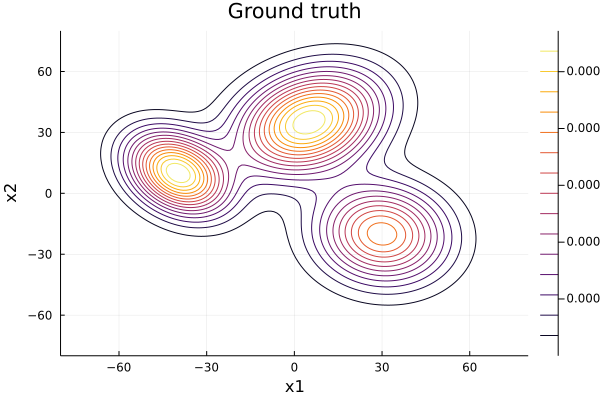

In [57]:
xrange = -80:80
cplot = contour(
    xrange, xrange, (x, y)->pdf(g_mixture, [x, y]),
    title="Ground truth",
    xlabel = "x1",
    ylabel = "x2",
)

# 観測データの生成

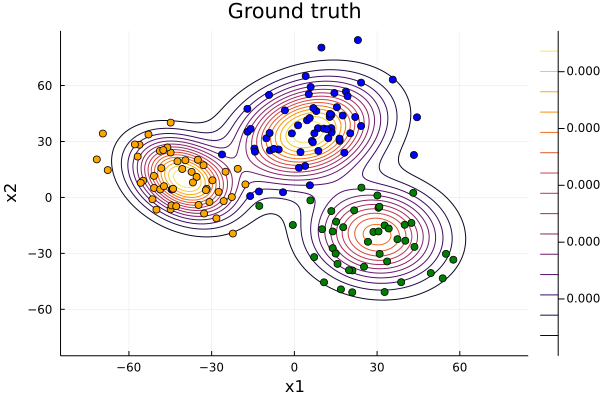

In [58]:
𝑁 = 150　# データ数
observations = rand(Multinomial(1, [π₁, π₂, π₃]), 𝑁)
categories = mapslices(argmax, observations, dims=1)

data = zeros(𝑁, 𝐷)

colors = [:blue, :orange, :green]

for n in 1:𝑁
    k = categories[n]
    x, y = data[n, :] = rand(𝒩[k])
    scatter!(cplot, [x], [y], color=colors[k], label=false)
end

cplot

# 変分推論

## 初期値の設定

In [94]:
# 観測データ
𝐗 = data;

In [95]:
# μの事前分布のパラメータを設定
β = 1.0
𝐦 = zeros(𝐷)

# λの事前分布のパラメータを設定
𝐖 = Matrix(1.0I, 𝐷, 𝐷)
ν = 𝐷

# πの事前分布のパラメータを設定
αₖ = [2., 2., 2.];

In [96]:
# 潜在変数の近似事後分布q(S)の期待値を初期化
_E_𝐒 = rand(Uniform(0, 1), 𝑁, 𝐾)
E_𝐒 = _E_𝐒 ./ sum(_E_𝐒, dims=2) # 正規化
E_𝐒[1:5, :]

5×3 Matrix{Float64}:
 0.449725  0.0872209  0.463055
 0.400826  0.452862   0.146312
 0.303936  0.546702   0.149362
 0.15231   0.57346    0.27423
 0.186127  0.532497   0.281377

In [93]:
# 初期値による近似事後分布q(μ)のパラメータを計算
β̂ₖ = vec(sum(E_𝐒, dims=1)) .+ β
𝐦̂ₖ = zeros(𝐾, 𝐷)
for k in 1:𝐾
    𝐦̂ₖ[k, :] = β .* 𝐦
    for n in 1:𝑁
        E_𝑠ₙₖ = E_𝐒[n, k]
        𝐱ₙ = 𝐗[n, :]
        𝐦̂ₖ[k, :] += E_𝑠ₙₖ * 𝐱ₙ
    end
    𝐦̂ₖ[k, :] = 𝐦̂ₖ[k, :] ./ β̂ₖ[k]
end

In [173]:
# 初期値による近似事後分布q(Λ)のパラメータを計算
𝐖̂⁻¹ₖ = zeros(𝐷, 𝐷, 𝐾)
for k in 1:𝐾
    𝐖̂⁻¹ₖ[:, :, k] = β * 𝐦 * 𝐦' - β̂ₖ[k] * 𝐦̂ₖ[k, :] * 𝐦̂ₖ[k, :]' + inv(𝐖)
    for n in 1:𝑁
        E_𝑠ₙₖ = E_𝐒[n, k]
        𝐱ₙ = 𝐗[n, :]
        𝐖̂⁻¹ₖ[:, :, k] += E_𝑠ₙₖ * 𝐱ₙ * 𝐱ₙ'
    end
end
𝐖̂ₖ = inv.(𝐖̂⁻¹ₖ)
ν̂ₖ = vec(sum(E_𝐒, dims=1)) .+ ν;

In [148]:
# 初期値による近似事後分布q(π)のパラメータを計算
α̂ₖ = vec(sum(E_𝐒, dims=1)) .+ αₖ;

## 更新式に必要な期待値の計算

In [203]:
E_𝚲ₖ = zeros(𝐷, 𝐷, 𝐾)
E_log_det𝚲ₖ = zeros(𝐾) 
E_𝚲ₖ𝛍ₖ = zeros(𝐾, 𝐷)
E_𝛍ᵀₖ𝚲ₖ𝛍ₖ = zeros(𝐾)

for k in 1:𝐾
    E_𝚲ₖ[:, :, k] = ν̂ₖ[k] * 𝐖̂ₖ[:, :, k]
    E_𝚲ₖ𝛍ₖ[k, :] = ν̂ₖ[k] * 𝐖̂ₖ[:, :, k] * 𝐦̂ₖ[k, :]
    E_𝛍ᵀₖ𝚲ₖ𝛍ₖ[k] = ν̂ₖ[k] * 𝐦̂ₖ[k, :]' * 𝐖̂ₖ[:, :, k] * 𝐦̂ₖ[k, :] + (𝐷 / β̂ₖ[k])
    for d in 1:𝐷
        E_log_det𝚲ₖ[k] = ψ((ν̂ₖ[k] + 1.0 - d) / 2) + 𝐷 * log(2) + logdet(𝐖̂ₖ[:, :, k])
    end
end



LoadError: InexactError: Float64(-13.846838698488142 + 3.141592653589793im)

In [204]:
logdet(𝐖̂ₖ[:, :, 1])

LoadError: DomainError with -1.0:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

In [155]:
log(Complex(tmp))

-18.41179692404789 + 3.141592653589793im

-17.025502562928 + 3.141592653589793im

3.178663864439859

In [161]:
ν̂ₖ

3-element Vector{Float64}:
 49.02582114120431
 55.71140979902298
 51.26276905977271